In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    return SVG(
        model_to_dot(
            model,
            show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

Using TensorFlow backend.


In [3]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from kerashistoryplot.callbacks import PlotHistory

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [4]:
from sklearn.model_selection import train_test_split

In [462]:
def make_data(num=1000, sort=True):
    x = np.linspace(0, 1, num=num)
    scale = x
    mean = 4 * x * ( 1 - x )
    y = mean + np.random.exponential(scale=scale, size=x.size)
    return x.reshape(-1, 1), y

X_train, y_train = make_data(num=100000)
X_test, y_test = make_data(num=10000)

X_plot = np.linspace(min(X_train), max(X_train), num=200).reshape(-1, 1)

In [463]:
quantiles = [0.001, 0.01, 0.25, 0.5, 0.75, 0.99, 0.999]
q_theor = np.hstack([
    -np.log(1 - q) * X_test + 4 * X_test * ( 1 - X_test )
    for q in quantiles
])

In [464]:
mean_theor = 4 * X_test * ( 1 - X_test ) + X_test

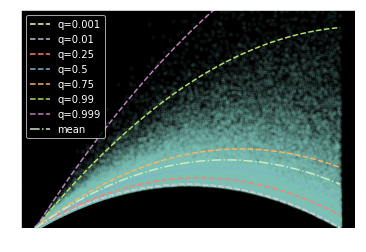

In [465]:
plt.plot(X_train, y_train, '.', alpha=0.05)
for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'q={q}')
plt.plot(X_test, mean_theor, '-.', label='mean')
plt.ylim(0, 5)
plt.legend()

In [466]:
import deepquantiles

from deepquantiles.losses import sk_quantile_loss

In [482]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_delta=0.001, min_lr=0.0001),
    EarlyStopping(monitor='loss', patience=15, min_delta=0.0001),
    PlotHistory(batches=False, n_cols=3, figsize=(15, 7))
]

# Individual Quantiles

In [483]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(),
    quantile_units=(32, 32, 32, 32, ),
    quantiles=quantiles,
    lr=0.01,
    epochs=100,
    batch_size=10000
)

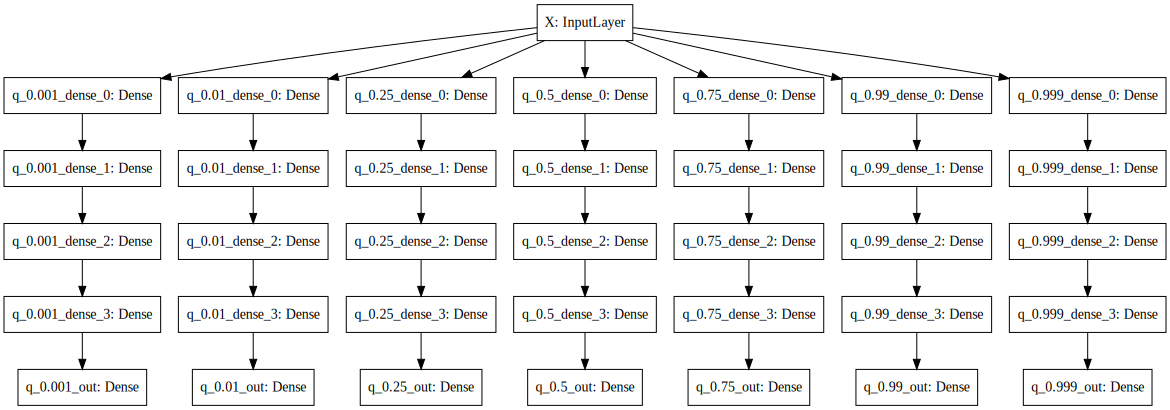

In [484]:
vis_model(regressor.model, show_shapes=False)

In [485]:
regressor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
q_0.001_dense_0 (Dense)         (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
q_0.01_dense_0 (Dense)          (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
q_0.25_dense_0 (Dense)          (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
q_0.5_dens

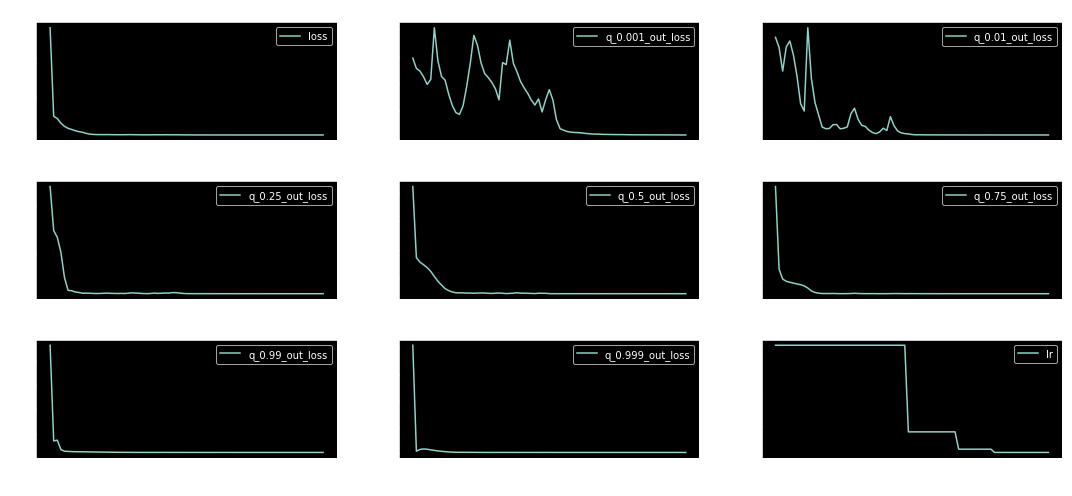

CPU times: user 5min 26s, sys: 51.5 s, total: 6min 17s
Wall time: 2min 29s


In [487]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks, shuffle=True)

In [495]:
%%time
q_preds = regressor.predict(X_test)

CPU times: user 53.2 ms, sys: 10.4 ms, total: 63.6 ms
Wall time: 18.2 ms


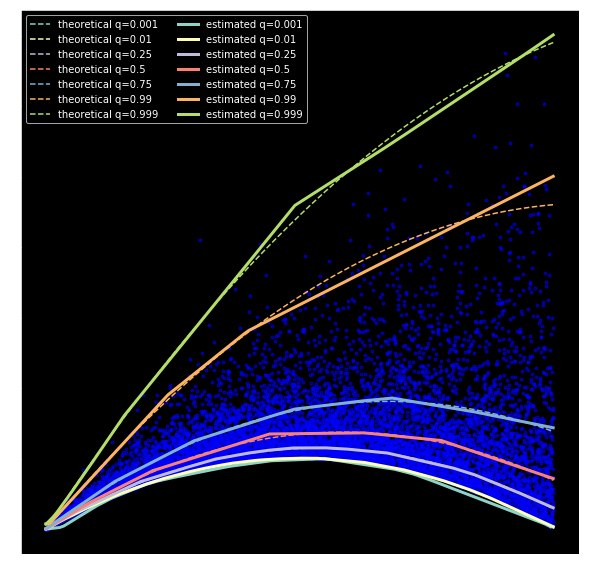

In [496]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

In [497]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 1.3 ms, sys: 818 µs, total: 2.12 ms
Wall time: 1.25 ms


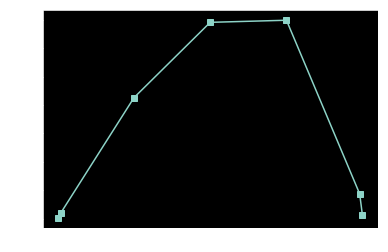

In [498]:
plt.plot(regressor.quantiles, scores, 's-')

# Multi-Quantile Regression

In [499]:
regressor = deepquantiles.MultiQuantileRegressor(
    shared_units=(32, 32, 32),
    quantile_units=(32, ),
    quantiles=quantiles,
    lr=0.01,
    epochs=100,
    batch_size=10000
)

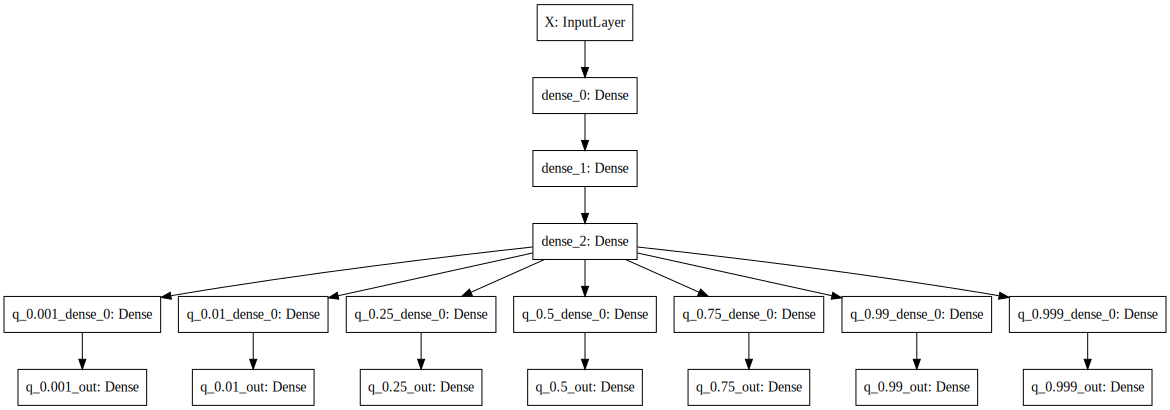

In [500]:
vis_model(regressor.model, show_shapes=False)

In [501]:
regressor.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
dense_0 (Dense)                 (None, 32)           64          X[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense_0[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
__________________________________________________________________________________________________
q_0.001_de

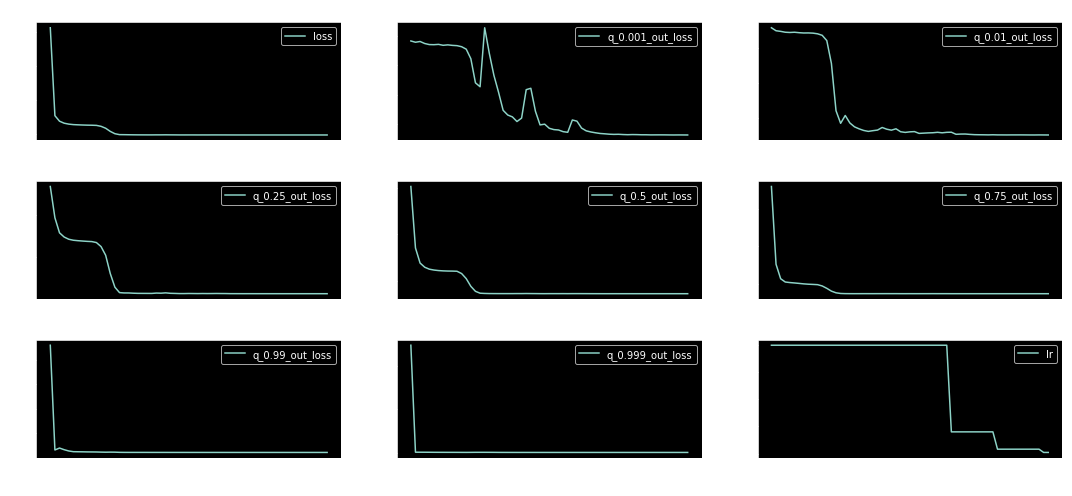

CPU times: user 3min 21s, sys: 23.9 s, total: 3min 45s
Wall time: 1min 43s


In [502]:
%%time
regressor.fit(X_train, y_train, verbose=1, callbacks=callbacks, shuffle=True)

In [503]:
%%time
q_preds = regressor.predict(X_test)

CPU times: user 2.79 s, sys: 54.1 ms, total: 2.84 s
Wall time: 2.83 s


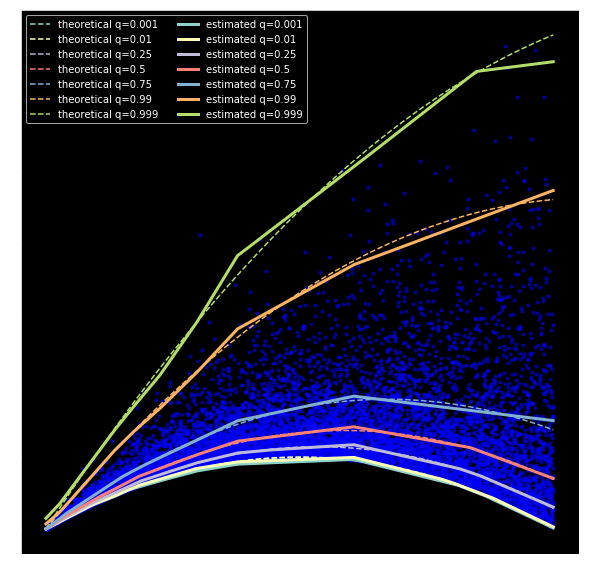

In [504]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

In [505]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 791 µs, sys: 443 µs, total: 1.23 ms
Wall time: 759 µs


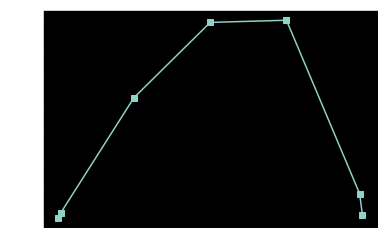

In [506]:
plt.plot(regressor.quantiles, scores, 's-')

In [507]:
%%time
print(X_test.shape)
samples = regressor.sample(X_test, num_samples=10000)
print(samples.shape)

(10000, 1)
(10000, 10000)
CPU times: user 3.26 s, sys: 734 ms, total: 3.99 s
Wall time: 3.95 s


In [508]:
mean_pred = samples.mean(axis=1)

In [509]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(mean_theor, mean_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(mean_theor, mean_pred)
print(rmse, mae)

0.10988379795112123 0.09394366860671705


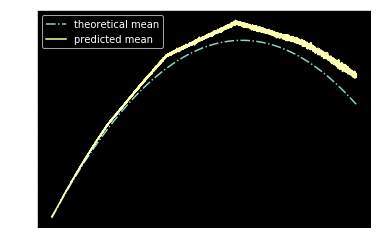

In [510]:
#plt.figure(figsize=(10, 10))
#plt.plot(X_test, y_test, 'b.', alpha=0.5)
plt.plot(X_test, mean_theor, '-.', label='theoretical mean')
plt.plot(X_test, mean_pred, label='predicted mean')
plt.legend()

## Regress on Quantile `q`

In [511]:
regressor = deepquantiles.CDFRegressor(
    feature_units=(32, 32, 32),
    quantile_units=(),
    shared_units=(32,),
    activation='relu',
    batch_norm=True,
    lr=0.01,
    epochs=100,
    batch_size=10000,
    q_mode='point',
    shuffle_points=True,
)

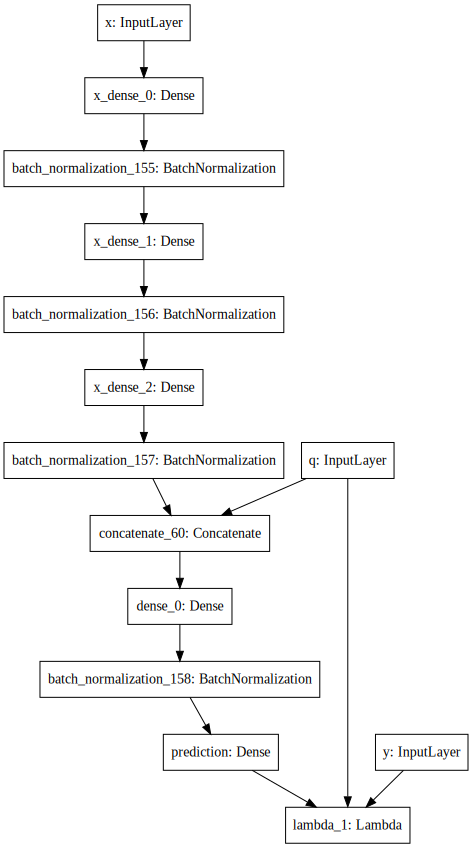

In [512]:
vis_model(regressor.model['loss'])

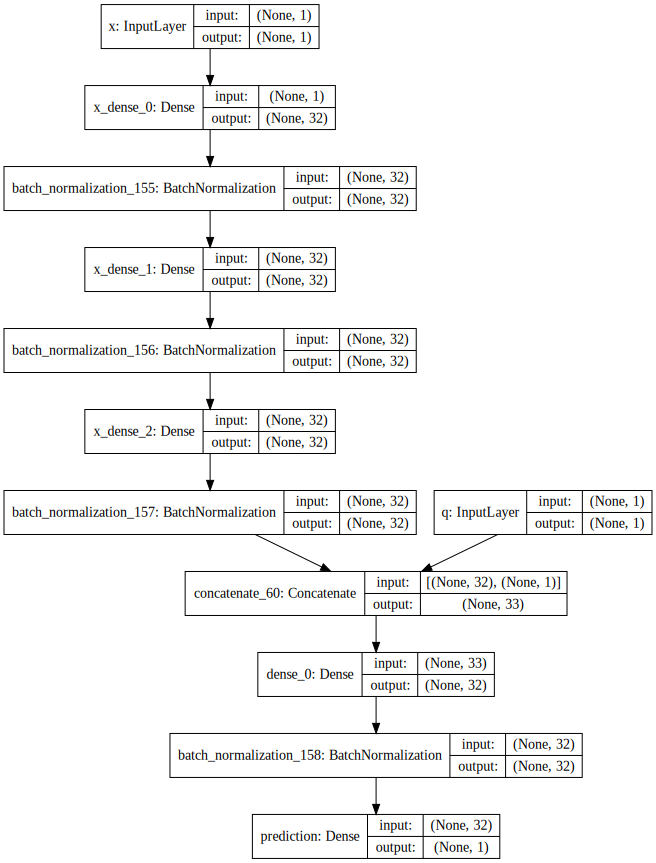

In [513]:
vis_model(regressor.model['quantile'], show_shapes=True)

In [514]:
regressor.model['quantile'].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
x_dense_0 (Dense)               (None, 32)           64          x[0][0]                          
__________________________________________________________________________________________________
batch_normalization_155 (BatchN (None, 32)           128         x_dense_0[0][0]                  
__________________________________________________________________________________________________
x_dense_1 (Dense)               (None, 32)           1056        batch_normalization_155[0][0]    
__________________________________________________________________________________________________
batch_norm

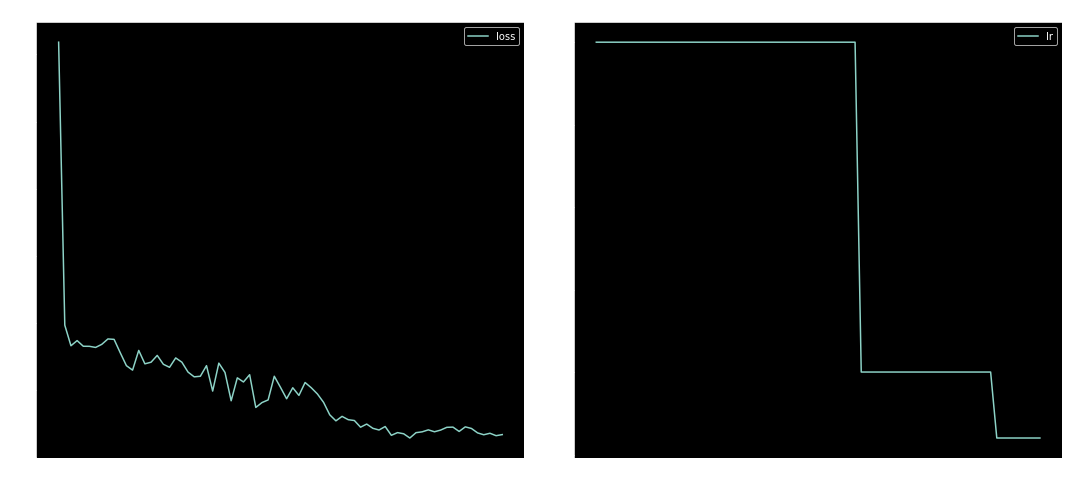

CPU times: user 55min, sys: 3min 30s, total: 58min 30s
Wall time: 20min 10s


In [562]:
%%time
regressor.fit(
    X_train, y_train,
    verbose=1, callbacks=callbacks, 
    epochs=100, batch_size=1000, 
    q_mode='adaptive', ada_num_quantiles=100
)

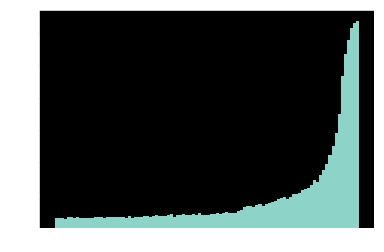

In [576]:
plt.hist(regressor.gen_.q, bins=100);

In [564]:
%%time
q_preds = regressor.predict(X_test, quantiles=quantiles)

CPU times: user 282 ms, sys: 26.8 ms, total: 308 ms
Wall time: 83.1 ms


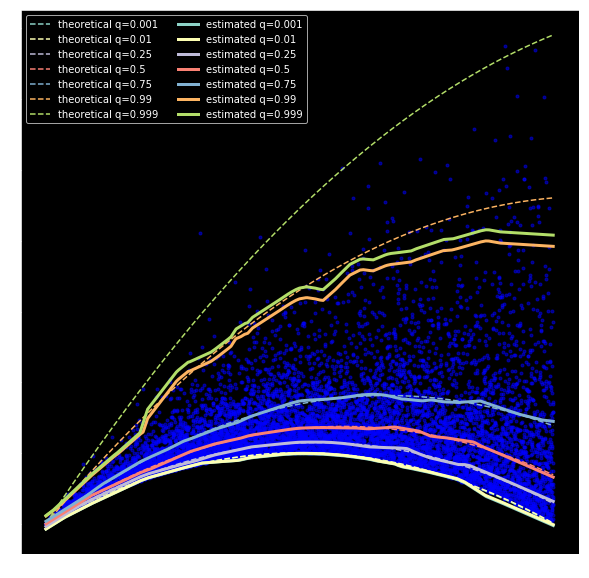

In [565]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds.T):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

In [566]:
%%time
scores = [sk_quantile_loss(q, y_test, q_pred) for q, q_pred in zip(quantiles, q_preds.T)]

CPU times: user 959 µs, sys: 459 µs, total: 1.42 ms
Wall time: 980 µs


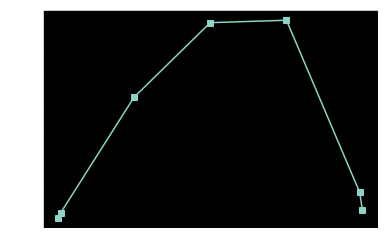

In [567]:
plt.plot(quantiles, scores, 's-')

In [568]:
%%time
print(X_test.shape)
samples = regressor.sample(X_test, num_samples=10000, num_quantiles=10)
print(samples.shape)

(10000, 1)
(10000, 10000)
CPU times: user 3.92 s, sys: 619 ms, total: 4.54 s
Wall time: 4.3 s


In [569]:
mean_pred = samples.mean(axis=1)

In [570]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(mean_theor, mean_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(mean_theor, mean_pred)
print(rmse, mae)

0.012604052885690463 0.010184347427294587


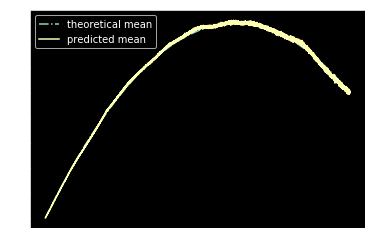

In [571]:
#plt.figure(figsize=(10, 10))
#plt.plot(X_test, y_test, 'b.', alpha=0.5)
plt.plot(X_test, mean_theor, '-.', label='theoretical mean')
plt.plot(X_test, mean_pred, label='predicted mean')
plt.legend()

## Gradient Boosting QR

In [359]:
from sklearn.ensemble import GradientBoostingRegressor

In [420]:
gbr = GradientBoostingRegressor(
    loss='quantile',
    n_estimators=250,
    max_depth=1,
    learning_rate=.1,
)

In [421]:
%%time
quantiles = quantiles
q_preds = []
scores = []
for q in quantiles:
    gbr.set_params(alpha=q)
    gbr.fit(X_train, y_train)
    q_pred = gbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

CPU times: user 2.91 s, sys: 10.1 ms, total: 2.92 s
Wall time: 2.94 s


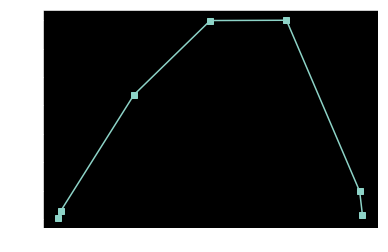

In [422]:
plt.plot(quantiles, scores, 's-')

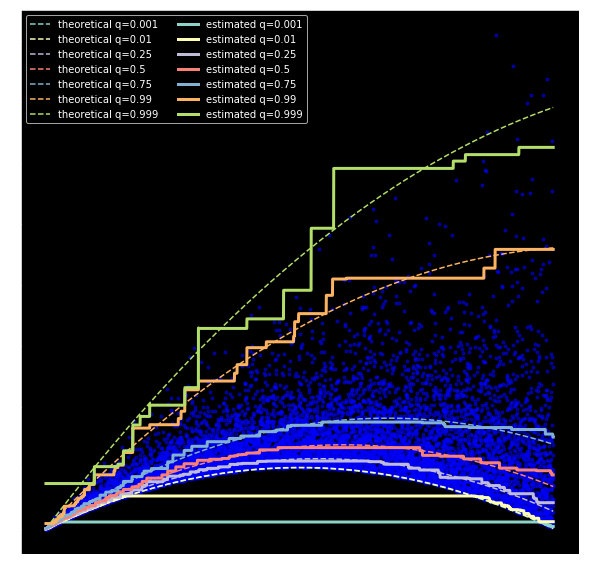

In [423]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)

## CatBoost

In [250]:
from catboost import CatBoostRegressor
from tqdm.autonotebook import tqdm

In [251]:
cbr = CatBoostRegressor(verbose=0)

In [252]:
quantiles = quantiles
q_preds = []
scores = []
for q in tqdm(quantiles):
    cbr.set_params(loss_function=f'Quantile:alpha={q}')
    cbr.fit(X_train, y_train)
    q_pred = cbr.predict(X_test)
    q_preds.append(q_pred)
    scores.append(sk_quantile_loss(q, y_test, q_pred))

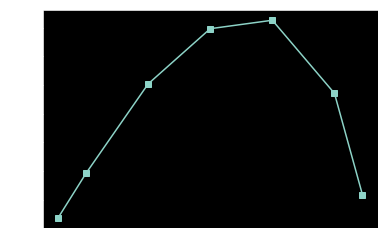

In [253]:
plt.plot(quantiles, scores, 's-')

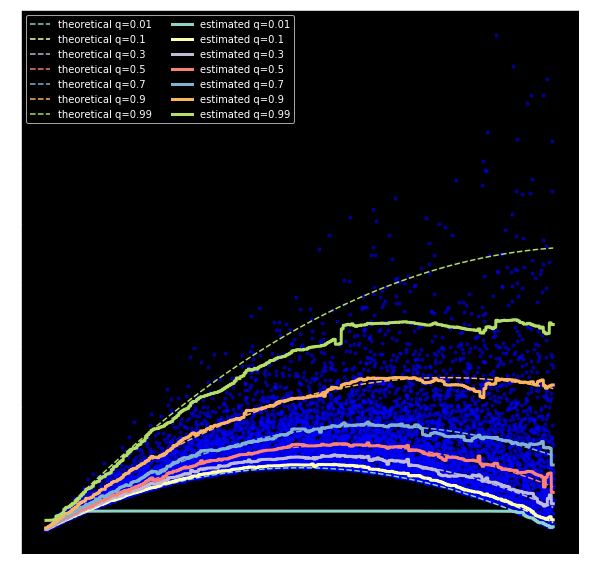

In [256]:
plt.figure(figsize=(10, 10))
plt.plot(X_test, y_test, 'b.', alpha=0.5)

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_theor.T):
    plt.plot(X_test, q_pred, '--', label=f'theoretical q={q}')

plt.gca().set_prop_cycle(None)

for q, q_pred in zip(quantiles, q_preds):
    plt.plot(X_test, q_pred, lw=3, label=f'estimated q={q}')

plt.legend(ncol=2)